In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [1]:
import numpy as np
import pandas as pd
import os
import random
import librosa as libr
import librosa.display as disp
from IPython.display import Audio
from scipy.io import wavfile

In [2]:
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torchaudio.transforms import Resample
from torchsummary import summary
from torch.utils.data import SubsetRandomSampler,Subset,DataLoader
from torchmetrics.audio import ScaleInvariantSignalNoiseRatio
from torchmetrics.audio import pesq as PESQ

In [3]:
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

NVIDIA RTX A5000
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [20]:
retrain = 0
save_per_epoch = 5
torch.manual_seed(0)

In [6]:
config = {
    'sample_rate':48000,
    'max_duration':4,
    'n_mfcc':40,
    'n_fft':1024,
    'hop_length':512,
    'n_mels':64,
    'batch_size':128,
    'learning_rate': 1e-5,
    'epochs':250,
    'val_split':0.9,
}

In [7]:
# !wget https://datashare.ed.ac.uk/bitstream/handle/10283/2791/clean_testset_wav.zip?sequence=1&isAllowed=y
# !wget https://datashare.ed.ac.uk/bitstream/handle/10283/2791/clean_trainset_28spk_wav.zip?sequence=2&isAllowed=y
# !wget https://datashare.ed.ac.uk/bitstream/handle/10283/2791/noisy_trainset_28spk_wav.zip?sequence=6&isAllowed=y
# !wget https://datashare.ed.ac.uk/bitstream/handle/10283/2791/noisy_testset_wav.zip?sequence=5&isAllowed=y

In [8]:
# !unzip "./data/noisy_trainset_28spk_wav.zip"
# !unzip "./data/clean_trainset_28spk_wav.zip"
# !unzip "./data/noisy_testset_wav.zip"
# !unzip "./data/clean_testset_wav.zip"

In [7]:
train_noisy_data_path = "./noisy_trainset_28spk_wav/"
train_clean_data_path = "./clean_trainset_28spk_wav/"
test_noisy_data_path = "./noisy_testset_wav/"
test_clean_data_path = "./clean_testset_wav/"

In [8]:
class AudioDataset(Dataset):
    def __init__(self,noisy_path,clean_path, transform=None, sample_rate=None,max_duration=None):

        #get file paths
        noisy_all_items = os.listdir(noisy_path)
        noisy_files = [item for item in noisy_all_items if os.path.isfile(os.path.join(noisy_path, item)) and item.lower().endswith('.wav')]
        noisy_file_paths = [os.path.join(noisy_path, file_name) for file_name in noisy_files]
        clean_file_paths = [os.path.join(clean_path, file_name) for file_name in noisy_files]

        #initialize variables
        self.noisy_data = noisy_file_paths
        self.clean_data = clean_file_paths
        self.transform = transform
        self.sample_rate = sample_rate
        self.max_duration = max_duration
        self.num_samples = sample_rate*max_duration

    def __len__(self):
        return len(self.noisy_data)

    def __getitem__(self, idx):
        noisy_waveform, sr = torchaudio.load(self.noisy_data[idx])
        noisy_waveform = torch.tensor(noisy_waveform.numpy().reshape(-1))
        if noisy_waveform.shape[0] < self.num_samples:
            num_missing_samples = self.num_samples - noisy_waveform.shape[0]
            noisy_waveform = F.pad(noisy_waveform, (0, num_missing_samples))
        noisy_waveform = torch.tensor(noisy_waveform[:self.num_samples])
        noisy_audio = noisy_waveform
        if self.transform:
            noisy_waveform = self.transform(noisy_waveform)


        clean_waveform, sr = torchaudio.load(self.clean_data[idx])
        clean_waveform = torch.tensor(clean_waveform.numpy().reshape(-1))
        if clean_waveform.shape[0] < self.num_samples:
            num_missing_samples = self.num_samples - clean_waveform.shape[0]
            clean_waveform = F.pad(torch.tensor(clean_waveform), (0, num_missing_samples))
        clean_waveform = torch.tensor(clean_waveform[:self.num_samples])
        clean_audio = clean_waveform
        if self.transform:
            clean_waveform = self.transform(clean_waveform)
        return noisy_waveform, clean_waveform, noisy_audio, clean_audio

In [9]:
def split_dataset(dataset, perc=0.9):
    dataset_indices = list(range(len(dataset)))
    random.shuffle(dataset_indices)
    train_indices = dataset_indices[:int(len(dataset_indices) * perc)]
    val_indices = dataset_indices[int(len(dataset_indices) * perc):]
    train_dataset = Subset(dataset, train_indices)
    val_dataset = Subset(dataset, val_indices)
    return train_dataset,val_dataset

In [10]:
mfcc_transform = torchaudio.transforms.MFCC(
                        sample_rate=config['sample_rate'],
                        n_mfcc=config['n_mfcc'],
                        melkwargs={"n_fft": config['n_fft'], "hop_length": config['hop_length'], 
                                   "n_mels": config['n_mels'],"center": False})

train_dataset = AudioDataset(noisy_path=train_noisy_data_path,
                       clean_path=train_clean_data_path,
                       sample_rate=config['sample_rate'],
                       max_duration=config['max_duration'],
                       transform=mfcc_transform)
test_dataset = AudioDataset(noisy_path=test_noisy_data_path,
                       clean_path=test_clean_data_path,
                       sample_rate=config['sample_rate'],
                       max_duration=config['max_duration'],
                       transform=mfcc_transform)

train_dataset, val_dataset = split_dataset(train_dataset,config['val_split'])

train_dataloader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=config['batch_size'], shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False)

print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {config['batch_size']}")
print(f"Length of val dataloader: {len(val_dataloader)} batches of {config['batch_size']}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {config['batch_size']}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7f15363a2850>, <torch.utils.data.dataloader.DataLoader object at 0x7f1543fe9190>)
Length of train dataloader: 82 batches of 128
Length of val dataloader: 10 batches of 128
Length of test dataloader: 7 batches of 128


In [14]:
class BaseUNetModel(nn.Module):
    def __init__(self):
        super(BaseUNetModel,self).__init__()
        self.down_conv_layer_1 = nn.Sequential(
            nn.Conv2d(1, 64 , kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
        )        
 
        self.down_conv_layer_2 = nn.Sequential(
            nn.Conv2d(64, 128 , kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2),
            
        ) 
    
        self.down_conv_layer_3 = nn.Sequential(
            nn.Conv2d(128, 256 , kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2),
            
        ) 
        
        self.down_conv_layer_4 = nn.Sequential(
            nn.Conv2d(256, 256 , kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5),   
        )

        self.down_conv_layer_5 = nn.Sequential(
            nn.Conv2d(256, 256 , kernel_size=4, stride=2, padding=1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.5),   
        ) 
        
        self.up_conv_layer_1 = nn.Sequential(
            nn.ConvTranspose2d(256, 256, kernel_size=(2,3), stride=2, padding=0),
            nn.InstanceNorm2d(256),
            nn.ReLU(), 
            nn.Dropout(0.5), 
        )
        
        self.up_conv_layer_2 = nn.Sequential(
            nn.ConvTranspose2d(512, 256, kernel_size=(3,2), stride=2, padding=0),
            nn.InstanceNorm2d(256),
            nn.ReLU(), 
            nn.Dropout(0.5), 
        )
        
        self.up_conv_layer_3 = nn.Sequential(
            nn.ConvTranspose2d(512, 128, kernel_size=(2,3), stride=2, padding=0),
            nn.InstanceNorm2d(128),
            nn.ReLU(), 
            nn.Dropout(0.5), 
        )

        self.up_conv_layer_4 = nn.Sequential(
            nn.ConvTranspose2d(256, 64, kernel_size=(4,3), stride=2, padding=(1,0)),
            nn.InstanceNorm2d(64),
            nn.ReLU(), 
        )
                
        self.upsample_layer = nn.Upsample(scale_factor=2)
        self.zero_pad = nn.ZeroPad2d((1, 0, 1, 0))
        self.conv_layer_final = nn.Conv2d(128, 1, kernel_size=4, padding=1)

    def forward(self,x):
        # print("x", x.shape)
        enc1 = self.down_conv_layer_1(x)
        # print("enc1", enc1.shape)
        enc2 = self.down_conv_layer_2(enc1) 
        # print("enc2", enc2.shape)
        enc3 = self.down_conv_layer_3(enc2) 
        # print("enc3", enc3.shape)
        enc4 = self.down_conv_layer_4(enc3)
        # print("enc4", enc4.shape)
        enc5 = self.down_conv_layer_5(enc4)
        # print("enc5", enc5.shape)

        dec1 = self.up_conv_layer_1(enc5)
        # print("dec1", dec1.shape)
        dec14 = torch.cat((dec1, enc4), 1)
        # print("dec14", dec14.shape)

        dec2 = self.up_conv_layer_2(dec14)
        # print("dec2", dec2.shape)
        dec23 = torch.cat((dec2, enc3), 1)
        # print("dec23", dec23.shape)

        dec3 = self.up_conv_layer_3(dec23)
        # print("dec3", dec3.shape)
        dec32 = torch.cat((dec3, enc2), 1)
        # print("dec32", dec32.shape)

        dec4 = self.up_conv_layer_4(dec32)
        # print("dec4", dec4.shape)
        dec41 = torch.cat((dec4, enc1), 1)
        # print("dec41", dec41.shape)

        final = self.upsample_layer(dec41)
        # print("up", final.shape)
        final = self.zero_pad(final)
        # print("zero", final.shape)
        final = self.conv_layer_final(final)
        # print("final", final.shape)
        return final

In [15]:
model = BaseUNetModel()
model = model.cuda()

rand_inp = torch.randn(128,1,40,374).cuda()
rand_out = model(rand_inp)
print(rand_out.shape)

torch.Size([128, 1, 40, 374])


In [16]:
summary(model,input_size=(1, 40,374), batch_size=128)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [128, 64, 20, 187]           1,088
         LeakyReLU-2         [128, 64, 20, 187]               0
            Conv2d-3         [128, 128, 10, 93]         131,200
    InstanceNorm2d-4         [128, 128, 10, 93]               0
         LeakyReLU-5         [128, 128, 10, 93]               0
            Conv2d-6          [128, 256, 5, 46]         524,544
    InstanceNorm2d-7          [128, 256, 5, 46]               0
         LeakyReLU-8          [128, 256, 5, 46]               0
            Conv2d-9          [128, 256, 2, 23]       1,048,832
   InstanceNorm2d-10          [128, 256, 2, 23]               0
        LeakyReLU-11          [128, 256, 2, 23]               0
          Dropout-12          [128, 256, 2, 23]               0
           Conv2d-13          [128, 256, 1, 11]       1,048,832
   InstanceNorm2d-14          [128, 256

In [16]:
# ssnr_fs = 22050
# ssnr = ScaleInvariantSignalNoiseRatio().cuda()

# def get_ssnr(preds, clean):
#     print(preds.shape, clean.shape)
#     inv_mel = preds.cpu().data.numpy()
#     S = libr.feature.inverse.mel_to_stft(inv_mel, sr=ssnr_fs)#config['sample_rate'])
#     preds_audio = libr.griffinlim(S)
#     ssnr_score = ssnr(preds_audio,clean).item()
#     return ssnr_score

In [17]:
# get_pesq_fs = 16000
# pesq = PESQ.PerceptualEvaluationSpeechQuality(get_pesq_fs,'nb').cuda()

# def get_pesq(preds, clean):
#     inv_mel = preds.cpu().data.numpy()
#     S = libr.feature.inverse.mel_to_stft(inv_mel, sr=ssnr_fs)#config['sample_rate'])
#     preds_audio = libr.griffinlim(S)
#     resampler = Resample(orig_freq=config['sample_rate'], new_freq=get_pesq_fs).cuda()
#     preds_resample = resampler(preds_audio)
#     clean_resample = resampler(clean)
#     pesq_score = pesq(preds_resample,clean_resample).item()
#     return pesq_score

In [17]:
def sample_preprop(transform):
    sample_path = './noisy_testset_wav/p232_001.wav'
    num_samples = config['max_duration']*config['sample_rate']

    noisy_sample, sr = torchaudio.load(sample_path)
    noisy_waveform = torch.tensor(noisy_sample.numpy().reshape(-1))
    if noisy_waveform.shape[0] < num_samples:
        num_missing_samples = num_samples - noisy_waveform.shape[0]
        noisy_waveform = F.pad(noisy_waveform, (0, num_missing_samples))
    noisy_waveform = torch.tensor(noisy_waveform[:num_samples])
    if transform:
        noisy_waveform = transform(noisy_waveform)
    noisy_waveform = noisy_waveform.unsqueeze(dim=0).unsqueeze(dim=0)
    return noisy_waveform
sample_noisy_waveform = sample_preprop(mfcc_transform)
print(sample_noisy_waveform.shape)

torch.Size([1, 1, 40, 374])


In [18]:
def save_inter_ouput(model,transform):
    noisy_waveform = sample_noisy_waveform.cuda()
    model = model.cuda()
    
    model.eval()
    pred = model(noisy_waveform).squeeze(1).squeeze(0)
    mel = pred.cpu().data.numpy()
    pred_audio = libr.feature.inverse.mel_to_stft(mel, sr=config['sample_rate'])
    return pred_audio

In [19]:
train_len = len(train_dataloader)
val_len = len(val_dataloader)
test_len = len(test_dataloader)
print(train_len,val_len,test_len)

82 10 7


In [21]:
model = BaseUNetModel()
model = model.cuda()

if retrain:
  PATH = './denoise_mfcc_model_250'
  model.load_state_dict(torch.load(PATH))
  print("loaded pretrained model..")
  

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])

train_losses,val_losses = [],[]
train_scores_ssnr,val_scores_ssnr = [],[]
train_scores_pesq,val_scores_pesq = [],[]
num_epochs = config['epochs']
intermediate_ouputs = {}

for epoch in range(1,num_epochs+1):

  model.train()
  epoch_loss,epoch_ssnr,epoch_pesq = 0.0,0.0,0.0

  for i, data in enumerate(train_dataloader, 0):
      # get the inputs; data is a list of [inputs, labels]
      X, y, noise , clean = data
      X = X.unsqueeze(1)
      X, y  = Variable(X.cuda()), Variable(y.cuda())
      # noise, clean = Variable(noise.cuda()),Variable(clean.cuda())

      optimizer.zero_grad()
      preds = model(X).squeeze(1)
      preds = preds.cuda()
      
      loss = criterion(preds.float(), y.float())
      # ssnr_score = get_ssnr(preds, clean)
      # pesq_score = get_pesq(preds, clean)

      loss.backward()
      optimizer.step()

      epoch_loss += loss.item()
      # epoch_ssnr += ssnr_score
      # epoch_pesq += pesq_score

  train_losses.append(epoch_loss)
  # train_scores_ssnr.append(epoch_ssnr)
  # train_scores_pesq.append(epoch_pesq)
  #print(f'Training: Epoch {epoch}/{num_epochs} Loss: {epoch_loss:.4f} SSNR: {epoch_ssnr:.4f} PESQ: {epoch_pesq:.4f}')
  print(f'Training: Epoch {epoch}/{num_epochs} MSE Loss: {epoch_loss:.4f} MSE LossperBatch: {epoch_loss/train_len:.4f}')
  if((epoch == 1) or (epoch%50 == 0)):
      intermediate_ouputs[str(epoch)] = save_inter_ouput(model,mfcc_transform)

  #Validation
  model.eval()
  val_loss,val_ssnr,val_pesq = 0.0,0.0,0.0
  with torch.no_grad():
    for i, data in enumerate(val_dataloader, 0):
      X_val, y_val, noise_val,clean_val = data
      X_val = X_val.unsqueeze(1)
      X_val, y_val = Variable(X_val.cuda()), Variable(y_val.cuda())
      # noise_val, clean_val = Variable(noise_val.cuda()),Variable(clean_val.cuda())

      preds_val = model(X_val).squeeze(1).cuda()
      val_loss += criterion(preds_val.float(), y_val.float()).item()
      # val_ssnr += get_ssnr(preds_val, clean)
      # val_pesq += get_pesq(preds_val, clean)

  val_losses.append(val_loss)
  # val_scores_ssnr.append(val_ssnr)
  # val_scores_pesq.append(val_pesq)
  # print(f'Validation: Epoch {epoch}/{num_epochs} Loss: {val_loss:.4f} SSNR: {val_ssnr:.4f} PESQ: {epoch_pesq:.4f}')
  
  print(f'Validation: MSE Loss: {val_loss:.4f} MSE LossperBatch: {val_loss/val_len:.4f}')
  if (epoch%save_per_epoch == 0):
    PATH = './denoise_mfcc_model_250'
    torch.save(model.state_dict(), PATH)
  print("=======================================")

Training: Epoch 1/250 MSE Loss: 158217.3445 MSE LossperBatch: 1929.4798
Validation: MSE Loss: 19153.2922 MSE LossperBatch: 1915.3292
Training: Epoch 2/250 MSE Loss: 143879.0704 MSE LossperBatch: 1754.6228
Validation: MSE Loss: 17443.8867 MSE LossperBatch: 1744.3887
Training: Epoch 3/250 MSE Loss: 130751.1166 MSE LossperBatch: 1594.5258
Validation: MSE Loss: 15937.1826 MSE LossperBatch: 1593.7183
Training: Epoch 4/250 MSE Loss: 118922.5884 MSE LossperBatch: 1450.2755
Validation: MSE Loss: 14566.0889 MSE LossperBatch: 1456.6089
Training: Epoch 5/250 MSE Loss: 108122.9369 MSE LossperBatch: 1318.5724
Validation: MSE Loss: 13311.6467 MSE LossperBatch: 1331.1647
Training: Epoch 6/250 MSE Loss: 98254.9988 MSE LossperBatch: 1198.2317
Validation: MSE Loss: 12165.2136 MSE LossperBatch: 1216.5214
Training: Epoch 7/250 MSE Loss: 89257.2395 MSE LossperBatch: 1088.5029
Validation: MSE Loss: 11120.5859 MSE LossperBatch: 1112.0586
Training: Epoch 8/250 MSE Loss: 81086.7742 MSE LossperBatch: 988.8631
V

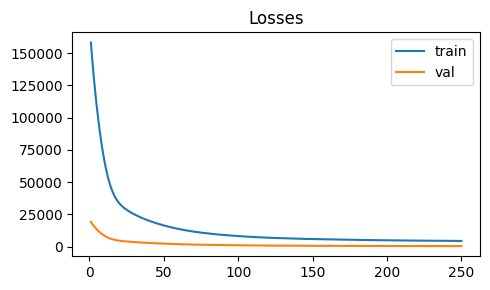

In [22]:
plt.figure(figsize=(5, 3))

# plt.subplot(1, 3, 1)
x = [i for i in range(1,len(train_losses)+1)]
plt.plot(x,train_losses, label='train')
plt.plot(x,val_losses, label='val')
plt.title('Losses')
plt.legend()

# plt.subplot(1, 3, 2)
# plt.plot(torch.tensor(train_scores_ssnr), label='train')
# plt.plot(torch.tensor(val_scores_ssnr), label='val')
# plt.title('SSNR Scores')
# plt.legend()

# plt.subplot(1, 3, 3)
# plt.plot(train_scores_pesq, label='train')
# plt.plot(val_scores_pesq, label='test')
# plt.title('PESQ Scores')
# plt.legend()

plt.tight_layout()
plt.show()

In [23]:
model.eval()
test_loss,test_ssnr,test_pesq = 0.0,0.0,0.0
with torch.no_grad():
  for i, data in enumerate(test_dataloader, 0):
    X, y, noise, clean = data
    X = X.unsqueeze(1)
    X, y = Variable(X.cuda()), Variable(y.cuda())

    preds = model(X).squeeze(1)
    preds = preds.cuda()

    loss = criterion(preds.float().squeeze(1), y.float())
    # ssnr_score = get_ssnr(preds, clean)
    # pesq_score = get_pesq(preds, clean)

    test_loss += loss.item()
    # test_ssnr += ssnr_score
    # test_pesq += pesq_score

print(f'Test: Loss: {test_loss:.4f} Test: LossperBatch: {test_loss/test_len:.4f} ')#SSNR: {test_ssnr:.4f} PESQ: {test_pesq:.4f}')

Test: Loss: 346.0364 Test: LossperBatch: 49.4338 


In [24]:
for k in intermediate_ouputs.keys():
    print(k, intermediate_ouputs[k].shape)

1 (1025, 374)
50 (1025, 374)
100 (1025, 374)
150 (1025, 374)
200 (1025, 374)
250 (1025, 374)


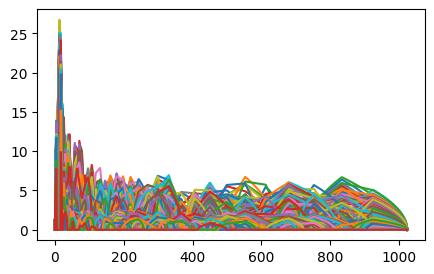

In [25]:
k = '1'
plt.figure(figsize=(5,3))
plt.plot(intermediate_ouputs[k])
Audio(intermediate_ouputs[k],rate=48000)

filtered_sample_path = 'mfcc_pred_001.wav'
wavfile.write(filtered_sample_path, 48000, intermediate_ouputs[k])

In [84]:
def get_sample_predicted_ouputs(id=0):
  test_audio,test_outputs, noisy_audio, clean_audio = next(iter(test_dataloader))
  outputs = model(test_audio.unsqueeze(dim=1).cuda()).squeeze(1)
  mfccs = outputs[id].cpu().data.numpy()
  pred_audio = libr.feature.inverse.mfcc_to_audio(mfccs, sr=config['sample_rate'],n_mels=config['n_mels'],
                                                  n_fft=config['n_fft'], hop_length=config['hop_length'],
                                                  win_length=config['n_fft'], center=False)
  # pred_audio = libr.griffinlim(S)
  print(noisy_audio[id].shape,clean_audio[id].shape, pred_audio.shape)
  print(test_audio[id].shape,test_outputs[id].shape, outputs[id].shape)
  return [noisy_audio[id],clean_audio[id], pred_audio],[test_audio[id],test_outputs[id],outputs[id]]

In [85]:
audio_outputs,mfcc_outputs = get_sample_predicted_ouputs(id=5)

torch.Size([192000]) torch.Size([192000]) (192000,)
torch.Size([40, 374]) torch.Size([40, 374]) torch.Size([40, 374])


In [86]:
Audio(audio_outputs[0], rate=48000)

In [87]:
Audio(audio_outputs[1], rate=48000)

In [36]:
s1 = audio_outputs[1]
s1.shape

torch.Size([192000])

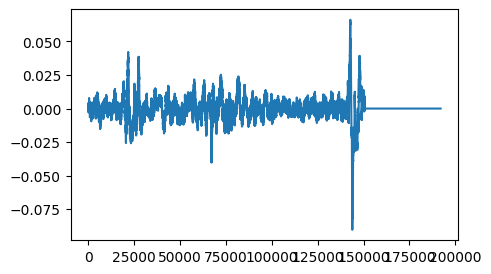

In [89]:
noise = audio_outputs[0] - audio_outputs[1]
plt.figure(figsize=(5,3))
plt.plot(noise)

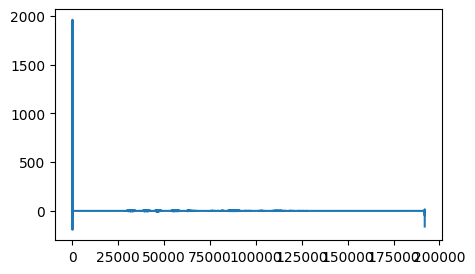

In [90]:
mini = min(audio_outputs[2].shape,audio_outputs[1].shape)[0]
noise = audio_outputs[2][:mini] - np.array(audio_outputs[1][:mini])
plt.figure(figsize=(5,3))
plt.plot(noise)


In [41]:
audio_outputs[2].shape

(190976,)

In [95]:
Audio(audio_outputs[2]*10000000000000, rate=48000)

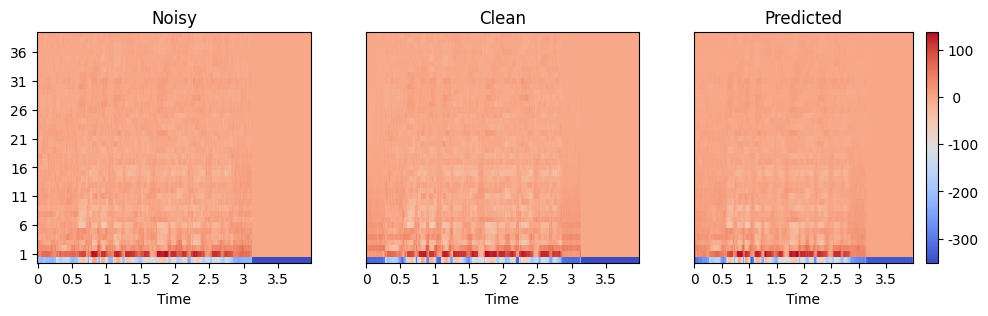

In [60]:
S1,S2,S3 = mfcc_outputs
S1 = S1.cpu().detach().numpy()
S2 = S2.cpu().detach().numpy()
S3 = S3.cpu().detach().numpy()

plt.figure(figsize=(12, 3))

plt.subplot(1, 3, 1)
img = libr.display.specshow(S1, x_axis='time', sr=config['sample_rate'])
plt.yticks(range(1,S1.shape[0],5))
plt.title('Noisy')

plt.subplot(1, 3, 2)
img = libr.display.specshow(S2, x_axis='time', sr=config['sample_rate'])
plt.title('Clean')

plt.subplot(1, 3, 3)
img = libr.display.specshow(S3, x_axis='time', sr=config['sample_rate'])
plt.title('Predicted')
plt.colorbar(img,format='%2.0f')
plt.savefig('mffc_pred_250')
plt.show()


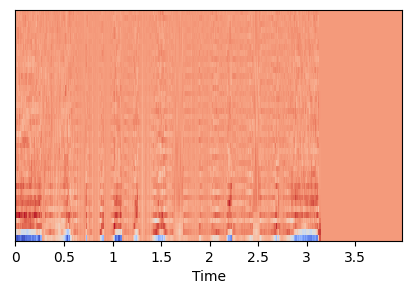

In [70]:
noise = S2 - S1
plt.figure(figsize=(5,3))
img = libr.display.specshow(noise, x_axis='time', sr=config['sample_rate'])

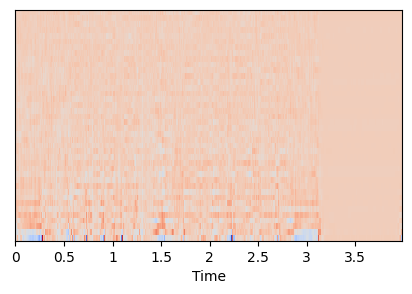

In [71]:
noise = S2 - S3
plt.figure(figsize=(5,3))
img = libr.display.specshow(noise, x_axis='time', sr=config['sample_rate'])

In [ ]:
# S = mel_outputs[2].cpu().detach().numpy()

# fig, ax = plt.subplots()
# S_dB = libr.power_to_db(S, ref=np.max)
# img = libr.display.specshow(S_dB, x_axis='time',
#                          y_axis='mel', sr=config['sample_rate'],
#                          fmax=8000, ax=ax)
# fig.colorbar(img, ax=ax, format='%+2.0f dB')
# ax.set(title='Mel-frequency spectrogram')
# # plt.savefig('pred.png')

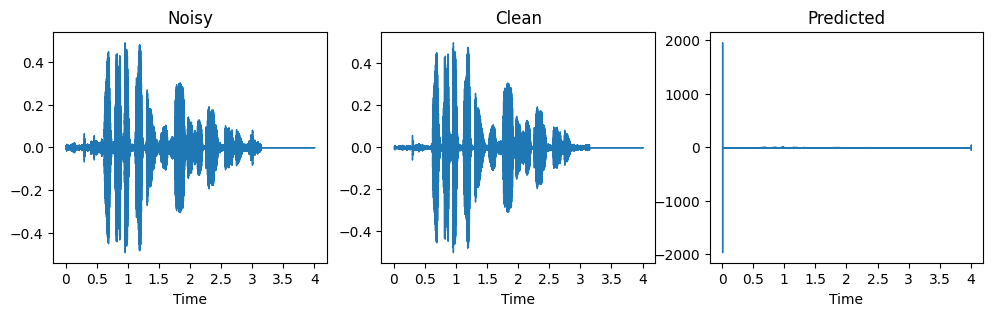

In [91]:
S1,S2,S3 = audio_outputs[0].numpy(),audio_outputs[1].numpy(),audio_outputs[2]
plt.figure(figsize=(12, 3))

plt.subplot(1, 3, 1)
disp.waveshow(S1,sr=config['sample_rate'])
plt.title('Noisy')

plt.subplot(1, 3, 2)
disp.waveshow(S2,sr=config['sample_rate'])
plt.title('Clean')

plt.subplot(1, 3, 3)
disp.waveshow(S3,sr=config['sample_rate'])
plt.title('Predicted')
# plt.savefig('mfcc_epoch_250.png')
plt.show()

In [75]:
S1.max(),S2.max(),S1.max(),S3.max()

(0.49176025, 0.5, 0.49176025, 1.100761)

In [76]:
S1.min(),S2.max(),S1.min(),S3.min()

(-0.39907837, 0.5, -0.39907837, -1.0891162)

In [77]:
def normalize_matrix(data):
    current_min = np.min(data)
    current_max = np.max(data)
    mapped_data = (data - current_min) / (current_max - current_min)
    # mapped_data = (mapped_data * (max_value - min_value)) + min_value
    return mapped_data

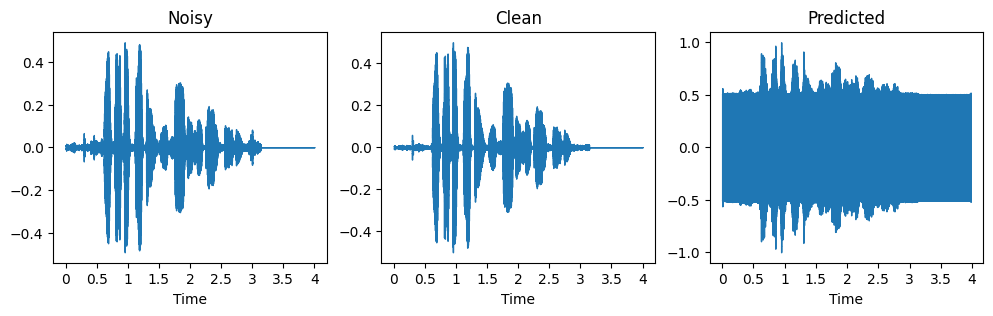

In [80]:
S3_norm = normalize_matrix(S3)

S1,S2,S3 = audio_outputs[0].numpy(),audio_outputs[1].numpy(),audio_outputs[2]
plt.figure(figsize=(12, 3))

plt.subplot(1, 3, 1)
disp.waveshow(S1,sr=config['sample_rate'])
plt.title('Noisy')

plt.subplot(1, 3, 2)
disp.waveshow(S2,sr=config['sample_rate'])
plt.title('Clean')

plt.subplot(1, 3, 3)
disp.waveshow(S3_norm,sr=config['sample_rate'])
plt.title('Predicted')
# plt.savefig('mfcc_epoch_250.png')
plt.show()

In [82]:
Audio(S3_norm, rate=48000)

In [83]:
Audio(S1, rate=48000)

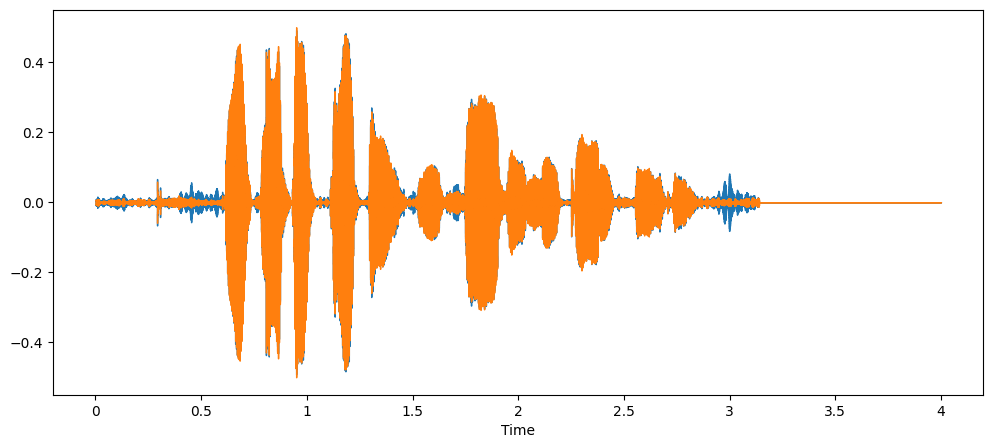

In [35]:
plt.figure(figsize=(12, 5))
disp.waveshow(S1,sr=config['sample_rate'],label='Noisy')
disp.waveshow(S2,sr=config['sample_rate'],label='Clean')
plt.show()

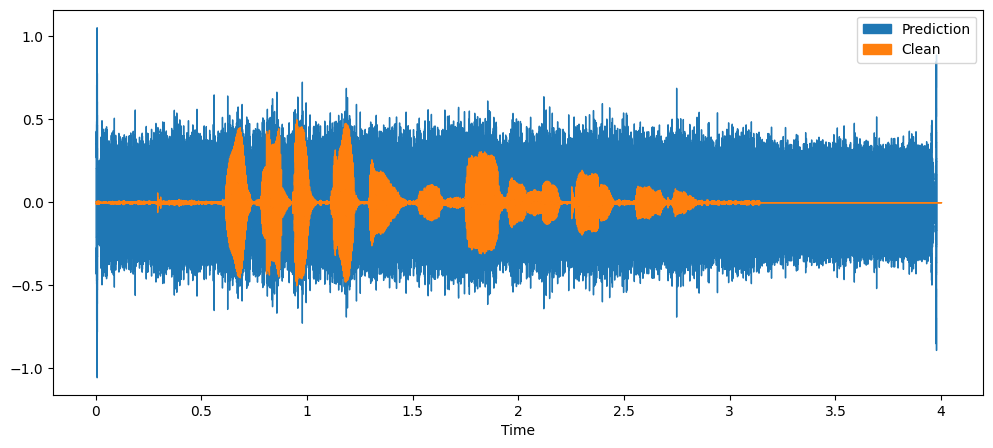

In [ ]:
plt.figure(figsize=(12, 5))
disp.waveshow(S3,sr=config['sample_rate'],label='Prediction')
disp.waveshow(S2,sr=config['sample_rate'],label='Clean')
plt.legend()
plt.show()

In [ ]:
# use torch metrics
# use a baseline model network
# use torch summary tensor board, callback

In [ ]:
PATH = './denoise_mfcc_model'
torch.save(model.state_dict(), PATH)